# CIFAR10을 CNN으로 학습하기. 여러 학습 방법으로 비교

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

#(8) learning rate decay
from torch.optim import lr_scheduler

batch_size=16
learning_rate=0.01
num_epoch=30

# 1. CIFAR10 train, test dataset 가져오기

MNIST: 11MB

In [2]:
# cifar_train=dset.CIFAR10("CIFAR10/",train=True, transform=transforms.ToTensor(),
#                          target_transform=None, download=True)

# cifar_test=dset.CIFAR10("CIFAR10/",train=False, transform=transforms.ToTensor(),
#                          target_transform=None, download=True)

#(2) Data augmentation
# cifar_train=dset.CIFAR10("CIFAR10/",train=True,
#                          transform=transforms.Compose([
#                              transforms.Scale(36),
#                              transforms.CenterCrop(32),
#                              transforms.RandomHorizontalFlip(),
#                              transforms.Lambda(lambda x: x.rotate(90)),
#                              transforms.ToTensor()
#                          ]))

#(4) Data Normalization
cifar_train=dset.CIFAR10("CIFAR10/",train=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                         ])
                         , target_transform=None, download=False)

cifar_test=dset.CIFAR10("CIFAR10/",train=False,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                         ])
                         , target_transform=None, download=False)




# 2. 대략적인 데이터 형태

('cifar_train \xea\xb8\xb8\xec\x9d\xb4:', 50000)
('cifar_test \xea\xb8\xb8\xec\x9d\xb4:', 10000)
('image data \xed\x98\x95\xed\x83\x9c:', torch.Size([3, 32, 32]))
('label:', 9)


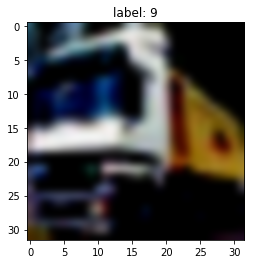

In [3]:
print ("cifar_train 길이:", len(cifar_train))
print ("cifar_test 길이:", len(cifar_test))

#데이터 하나 형태
image, label = cifar_train.__getitem__(1) #1번째 데이터
print ("image data 형태:", image.size())
print ("label:", label)

#그리기
img = image.numpy() #image 타입을 numpy로 변환 (3,32,32) rgb, W, H

#(3,32,32)->(32,32,3)
r,g,b = img[0,:,:],img[1,:,:],img[2,:,:]
#img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0],img2[:,:,1],img2[:,:,2] = r,g,b

plt.title("label: %d" %label)
plt.imshow(img2,interpolation='bicubic')
plt.show()

In [4]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader): #batch_size만큼
        img = Variable(imgs) #x
        #label = Variable(labels) #y
        label = Variable(labels)
        
        output = imodel.forward(img)
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [5]:
# === 3. 데이터 로드함수 ===
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True,num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# === 4. 모델 선언 ===
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0.2), #(1)
            nn.BatchNorm2d(16), #(5)
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0.2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8, 100),
            nn.ReLU(),
            #nn.Dropout2d(0.2),
            nn.BatchNorm1d(100),
            nn.Linear(100,10)
        )
        
        #(3) weight initializaion
        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         init.kaiming_normal_(m.weight.data) #REUL 일 때
        #         m.bias.data.fill_(0)
        #     if isinstance(m, nn.Linear):
        #         init.kaiming_normal_(m.weight.data)
        #         m.bias.data.fill_(0)
    
    def forward(self,x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)
        
        return out
model=CNN()

In [ ]:
  # === 5. loss, optimizer ===
loss_func=nn.CrossEntropyLoss()
#optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate) #(6) Adam optimizer

#scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2) #(7) learning rate decay

model.train()
# === 6. 학습 ===
for i in range(num_epoch):
    for j,[image, label] in enumerate(train_loader):
        x=Variable(image)
        y_=Variable(label)
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j%3000==0:
            print(i,j,loss)

(0, 0, tensor(2.2910, grad_fn=<NllLossBackward>))
(0, 3000, tensor(0.4448, grad_fn=<NllLossBackward>))
(1, 0, tensor(1.4697, grad_fn=<NllLossBackward>))
(1, 3000, tensor(0.9431, grad_fn=<NllLossBackward>))
(2, 0, tensor(1.2527, grad_fn=<NllLossBackward>))
(2, 3000, tensor(0.5195, grad_fn=<NllLossBackward>))
(3, 0, tensor(0.5581, grad_fn=<NllLossBackward>))
(3, 3000, tensor(1.0598, grad_fn=<NllLossBackward>))
(4, 0, tensor(0.6756, grad_fn=<NllLossBackward>))
(4, 3000, tensor(0.5232, grad_fn=<NllLossBackward>))
(5, 0, tensor(0.6221, grad_fn=<NllLossBackward>))
(5, 3000, tensor(0.8216, grad_fn=<NllLossBackward>))
(6, 0, tensor(0.5362, grad_fn=<NllLossBackward>))
(6, 3000, tensor(0.4235, grad_fn=<NllLossBackward>))
(7, 0, tensor(0.3571, grad_fn=<NllLossBackward>))
(7, 3000, tensor(1.2387, grad_fn=<NllLossBackward>))
(8, 0, tensor(0.5388, grad_fn=<NllLossBackward>))
(8, 3000, tensor(0.2655, grad_fn=<NllLossBackward>))
(9, 0, tensor(0.4160, grad_fn=<NllLossBackward>))
(9, 3000, tensor(0.3173

## (0) Naive Test

In [0]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 67.2699966430664


## (1) drop out

In [0]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 61.459999084472656


## (2) Data augmentation

In [0]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 23.119998931884766


## (3) Wieght initialization

In [0]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 69.72999572753906


## (4) Data Normalization

In [0]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 67.29999542236328


## (5) Batch normalization

In [0]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 70.12999725341797


## (6) Adam optimizer

In [0]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 67.29000091552734


## (7) learning rate decay

In [0]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 65.5


(8) Data Normalization + Batch normalization



In [11]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 71.33999633789062


(9) Data Normalization + Batch normalization + epoch 100

In [0]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 70.5999984741211


Data Normalization + Batch normalization + lr=0.005

In [20]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 72.41999816894531


Data Normalization + Batch normalization + lr=0.01

In [51]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 74.62999725341797


Data Normalization + Batch normalization + lr=0.05

In [35]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 72.97000122070312


Data Normalization + Batch normalization + lr=0.025

In [43]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 73.69999694824219


In [83]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 70.75


Data Normalization + Batch normalization + lr=0.01 + Aadam optimizer

In [60]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 73.9000015258789


In [91]:
model.eval()
ComputeAccr(test_loader, model)

Accuracy of Test Data: 71.5199966430664
